# Credit Card Fraud Detection


For this problem, I will be exploring the Kaggle dataset found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) which contains almost 300k entries of Credit Card transactions during two days from the month of September, 2013. 

PCA has been used on the dataset, and so for the most part there are only unknown numerical features left, i.e. the 28 (V1-V28) principal components.

I am going to be doing this in Google Colab, so I will need to prepare my Colab Notebook to be able to download the dataset straight from Kaggle into the environment.


In [1]:
# Mount the drive
from google.colab import drive
from google.colab import files 
drive.mount('/content/gdrive')

# Upload the kaggle.json file holding our API information
files.upload() 

# Install and configure the kaggle CLI
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Download and unzip dataset inside our project folder
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content/gdrive/MyDrive/Kaggle/FraudDetection
!unzip /content/gdrive/MyDrive/Kaggle/FraudDetection/creditcardfraud.zip -d /content/gdrive/MyDrive/Kaggle/FraudDetection

## Dependencies

First I will see how far I can get with a simple Logistic Regression model, so I will need to import some things from Scikit-Learn. I will also import the keras backend to TensorFlow so that I can explore a deep learning approach later on as well.

In [2]:
# Import dependencies
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

### Preprocessing and Visualization

Let's explore the data and see what we can learn before we apply any modeling.

In [3]:
# Read the csv into a pandas DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/Kaggle/FraudDetection/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


There are 284807 rows of data and 31 columns. The columns are:  

1. A 'Time' column which represents the time (in seconds) that have passed for each transaction since the beginning of the dataset
2. The 28 principal components (V1-V28)
3. An 'Amount' column which represents the transaction amount
4. The 'Class' column which represets frad vs non-fraud.


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No missing data

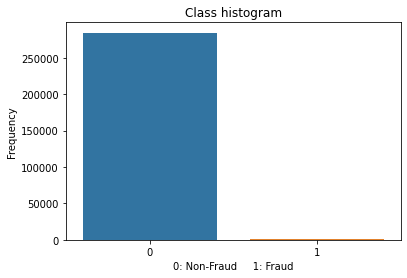

In [6]:
ax = sns.countplot(x=df.Class, data=df).set(title='Class histogram', xlabel='0: Non-Fraud     1: Fraud', ylabel='Frequency')

In [7]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Huge class imbalance problem. Only 492 out of the 284807 transactions are actually fraudulent. Accuracy will not be a great performance metric for a model. A better approach would be ROC techniques (Precision/Recall). Another option would be to undersample the non-fraud transactions in order to obtain an equal dataset.

In [8]:
# Scaling the 'Amount' and 'Time' columns

df['Amount_adj'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time_adj'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(columns=['Amount', 'Time'], inplace=True)

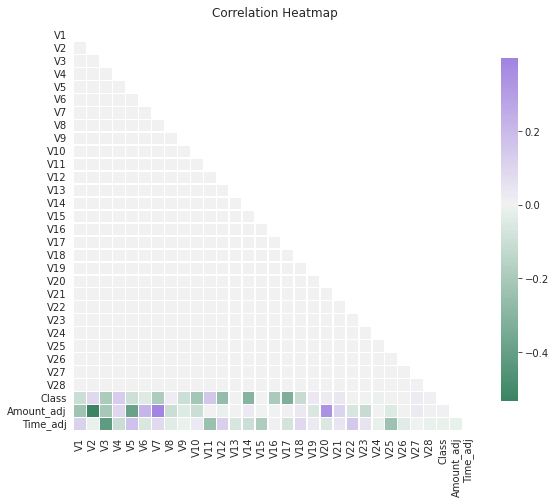

In [9]:
corr = df.corr() # Correlation Matrix

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True  # Making sure we only get bottom left triangle of correlations

cmap = sns.diverging_palette(150, 275, as_cmap=True) # Nicer color map

with sns.axes_style("white"):            # Hiding masked part
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, center=0, linewidths=0.5, cbar_kws={"shrink": 0.7})
    ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Because of the nature of the PCA algorithm, the majority of the features (all of the principal components) do no correlate, therefore the only squares with any color on a correlation heatmap are the ones including either the "amount" or "time" columns of the data. This lets us see how correlated each of the components is with respect to both the time and the amount of each transaction. Unfortunately, this does not provide much use. 

# First method: Logistic Regression

In [10]:
X = df.drop(columns=['Class'])    # feature matrix
y = df.Class.values               # label vector

In [11]:
# Split some of our training data to become testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [12]:
clf = LogisticRegression().fit(X_train, y_train)      

In [13]:
# Testing Metrics
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, y_probs)*100
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)
print(f"AUC: {auc}")
print(metrics.classification_report(y_test, y_pred, digits=4))

Confusion matrix:
 [[56852     9]
 [   37    64]]
AUC: 97.77959488145575
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     56861
           1     0.8767    0.6337    0.7356       101

    accuracy                         0.9992     56962
   macro avg     0.9380    0.8168    0.8676     56962
weighted avg     0.9991    0.9992    0.9991     56962



Here the recall is ~0.63, which can definitely be improved, while the precision is ~0.87. The AUC Score is 97.78, very high but makes sense due to our vastly imbalanced problem. False negatives mean not catching a fraudulent transaction (obviously a big deal), meanwhile false positives means mistaking a fair transaction for being fraudulent (i.e. a false alarm, still annoying and can cause customer frustration and would require fixing, but not as big of a problem as actual fraud). Therefore recall (TP / (TP + FN)) is more important in this scenario, and so it might be a good idea to sacrifice some precisison (TP / (TP + FP)) for an increased recall. Lets look at the ROC.

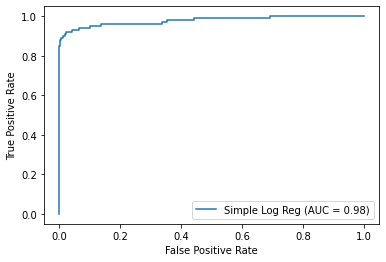

In [14]:
# Taking a look at the ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs, drop_intermediate=True)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Simple Log Reg")
ax = display.plot()

In [15]:
# Adjusting threshold down to 10%
adj_probs = (y_probs > 0.10) * 1
adj_cm = metrics.confusion_matrix(y_test, adj_probs)
print('Confusion matrix:\n', adj_cm)
print(metrics.classification_report(y_test, adj_probs, digits=4))

Confusion matrix:
 [[56845    16]
 [   20    81]]
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56861
           1     0.8351    0.8020    0.8182       101

    accuracy                         0.9994     56962
   macro avg     0.9173    0.9008    0.9089     56962
weighted avg     0.9994    0.9994    0.9994     56962



After lowering the threshold to 10%, the recall increased ~.17 from ~.63 to ~.80. Still not perfect, but way better as now there are way fewer false negatives. There are more false positives now and so the precision fell from ~0.87 to ~0.83, but I assume banks would rather deal with a little more false alarms and way less frauds than vice versa.

Will using a deep neural network have better results?

In [16]:
# Using a DNN with 3 hidden layers (128, 64, 32), and tanh activation functions for each. Also 25% dropout to prevent overfitting.
# Last layer needs to be able to classify between freud and non-fraud so it is left with a size of 1, sigmoid activation, and binary crossentropy is
# chosen for the loss function. 
model = keras.Sequential()
model.add(keras.layers.Dense(128, input_shape=(30,), activation='tanh'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(64, activation='tanh'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(32, activation='tanh'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation='sigmoid'))
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
 
model.fit(X_train, y_train, epochs=30, batch_size=100)

Epoch 1/30
2279/2279 [==============================] - 7s 3ms/step - loss: 0.0171 - auc: 0.9033
Epoch 2/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0036 - auc: 0.9261
Epoch 3/30
2279/2279 [==============================] - 7s 3ms/step - loss: 0.0035 - auc: 0.9326
Epoch 4/30
2279/2279 [==============================] - 7s 3ms/step - loss: 0.0034 - auc: 0.9365
Epoch 5/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0033 - auc: 0.9417
Epoch 6/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0031 - auc: 0.9431
Epoch 7/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0031 - auc: 0.9444
Epoch 8/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0030 - auc: 0.9431
Epoch 9/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0028 - auc: 0.9533
Epoch 10/30
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0029 - auc: 0.9533
Epoch 11/30
2279/2279 [======

In [17]:
# Since keras returns probabilities, we need to manually transform them into predictions
# Setting threshold to default 50%

tf_probs = model.predict(X_test)
tf_preds = (tf_probs > 0.5).reshape(-1)*1  

In [18]:
# Testing Metrics
auc_tf = metrics.roc_auc_score(y_test, tf_probs)*100
cm_tf = metrics.confusion_matrix(y_test, tf_preds)
print('Confusion matrix:\n', cm_tf)
print(f"AUC: {auc_tf}")
print(metrics.classification_report(y_test, tf_preds, digits=4))

Confusion matrix:
 [[56854     7]
 [   20    81]]
AUC: 95.72009108193491
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56861
           1     0.9205    0.8020    0.8571       101

    accuracy                         0.9995     56962
   macro avg     0.9601    0.9009    0.9285     56962
weighted avg     0.9995    0.9995    0.9995     56962



Although the AUC score is a bit lower, the other results from the DNN are even better than the ones from the threshold-adjusted Logistic Regression. Recall is ~0.84 and Precision at ~0.88. Lets graph the ROC for both methods and compare.

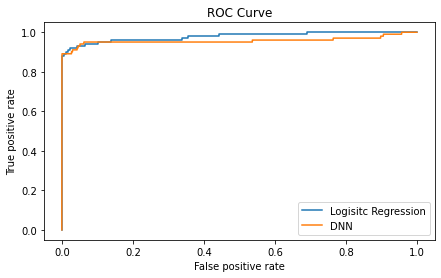

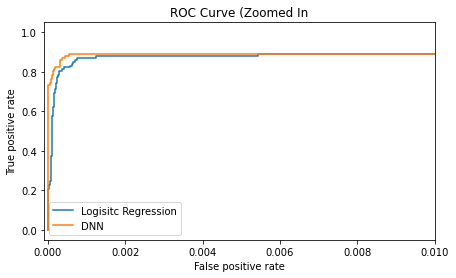

In [19]:
# Taking a look at the ROC
fpr_tf, tpr_tf, thresholds_tf = metrics.roc_curve(y_test, tf_probs, drop_intermediate=True)

# with plt.xkcd() as style:
plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf)
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN'])


plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf)
plt.xlim((-0.0001,0.01))
plt.title('ROC Curve (Zoomed In')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN'])


Both of the figures are the same, the bottom is just more zoomed in for clarity. 

The DNN did in fact produce better results. The DNN ROC is a bit more up and to the left than the LR ROC, and the only reason why the AUC was higher with the LR approach is because of the top portion of the graph where the LR curve is higher than the DNN curve, but that is for False Positive Rates that are way too high and not ones we'd ever want, so our threshold would never be chosen to get us on that section of the curve.

Now its time for undersampling. We have to shuffle the original DataFrame and only work with as many Non-Fraud samples as we have Fraud ones (492).

In [20]:
# Shuffling
shuffled_df = df.sample(frac=1)

In [21]:
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0][:492]

combined_df = pd.concat([fraud_df, non_fraud_df])

under_sample_df = combined_df.sample(frac=1, random_state=42)

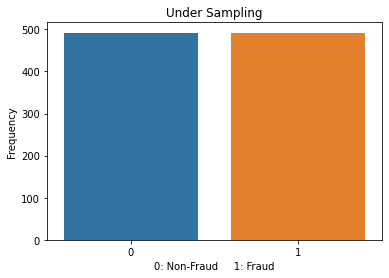

In [22]:
ax = sns.countplot(x=under_sample_df.Class, data=under_sample_df).set(title='Under Sampling', xlabel='0: Non-Fraud     1: Fraud', ylabel='Frequency')

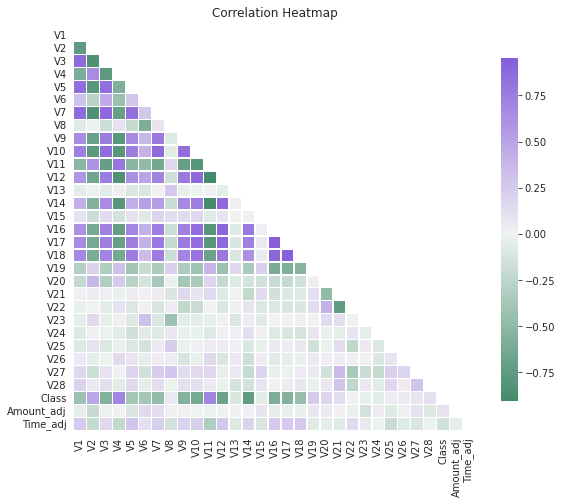

In [23]:
corr = under_sample_df.corr() # Correlation Matrix

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True  # Making sure we only get bottom left triangle of correlations

cmap = sns.diverging_palette(150, 275, as_cmap=True) # Nicer color map

with sns.axes_style("white"):            # Hiding masked part
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, center=0, linewidths=0.5, cbar_kws={"shrink": 0.7})
    ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Undersampling the non-fraud cases in order to equalize our dataset uncovered some correlations that weren't previously clear. This might not be a good sign, as it showcases that there is information loss due to the undersampling. Normally, the principal components should not be correlated whatsoever, but since there is way less data than normal here, some correlations can be seen which is not actually a good thing in this case.

In [24]:
X_us = under_sample_df.drop(columns=['Class'])    # feature matrix (under sampled)
y_us = under_sample_df.Class.values               # label vector (under sampled)

In [25]:
# Split some of our training data to become testing data.
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.2, random_state=0) 

In [26]:
clf_us = LogisticRegression().fit(X_train_us, y_train_us)      

In [27]:
# Testing Metrics
y_pred_us = clf_us.predict(X_test_us)
y_probs_us = clf_us.predict_proba(X_test_us)[:, 1]
auc_us = metrics.roc_auc_score(y_test_us, y_probs_us)*100
cm_us = metrics.confusion_matrix(y_test_us, y_pred_us)
print('Confusion matrix:\n', cm_us)
print(f"AUC: {auc_us}")
print(metrics.classification_report(y_test_us, y_pred_us, digits=4))

Confusion matrix:
 [[103   3]
 [  7  84]]
AUC: 98.8077959776073
              precision    recall  f1-score   support

           0     0.9364    0.9717    0.9537       106
           1     0.9655    0.9231    0.9438        91

    accuracy                         0.9492       197
   macro avg     0.9509    0.9474    0.9488       197
weighted avg     0.9498    0.9492    0.9491       197



The AUC is higher, but the scores can be a bit deceiving. It might look like our recall and precision are pretty high up for fraudulent transactions, but our scores for non-fraud ones came down, and therefore the averages did as well. It is not entirely clear if this is better or worse. What can be seen from the ROC?

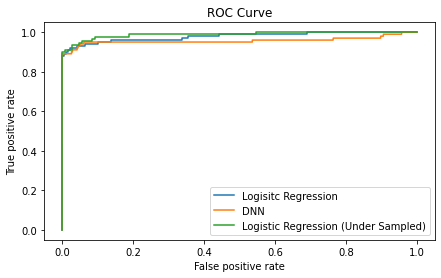

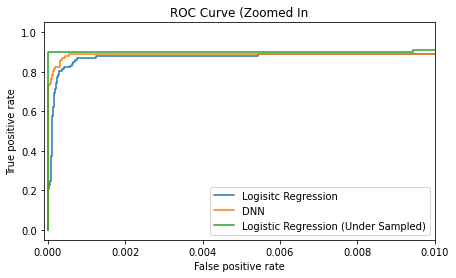

In [28]:
# Taking a look at the ROC
fpr_us, tpr_us, thresholds_us = metrics.roc_curve(y_test_us, y_probs_us, drop_intermediate=True)

# with plt.xkcd() as style:
plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf, fpr_us, tpr_us)
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN', 'Logistic Regression (Under Sampled)'])


plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf, fpr_us, tpr_us)
plt.xlim((-0.0001,0.01))
plt.title('ROC Curve (Zoomed In')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN', 'Logistic Regression (Under Sampled)'])

So looking at the ROC, we can now see that the undersampling did in fact help, and it looks like we are getting a much better ROC than before. What is we adjusted the threshold?

In [43]:
# Adjusting under sampling threshold down to 30%
adj_probs_us = (y_probs_us > 0.30) * 1
adj_cm_us = metrics.confusion_matrix(y_test_us, adj_probs_us)
print('Confusion matrix:\n', adj_cm_us)
print(metrics.classification_report(y_test_us, adj_probs_us, digits=4))

Confusion matrix:
 [[101   5]
 [  5  86]]
              precision    recall  f1-score   support

           0     0.9528    0.9528    0.9528       106
           1     0.9451    0.9451    0.9451        91

    accuracy                         0.9492       197
   macro avg     0.9489    0.9489    0.9489       197
weighted avg     0.9492    0.9492    0.9492       197



After some tweaking of the threshold to get the highest F1 avg score, I settled with 30%, which is only fractionally better than not adjusting it. Seems as if the default threshold was good enough. 

Deep learning approach with the undersampled dataset?

In [30]:
model_us = keras.Sequential()
model_us.add(keras.layers.Dense(128, input_shape=(30,), activation='tanh'))
model_us.add(keras.layers.Dropout(0.25))
model_us.add(keras.layers.Dense(64, activation='tanh'))
model_us.add(keras.layers.Dropout(0.25))
model_us.add(keras.layers.Dense(32, activation='tanh'))
model_us.add(keras.layers.Dropout(0.25))
model_us.add(keras.layers.Dense(1, activation='sigmoid'))
 
model_us.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
 
model_us.fit(X_train_us, y_train_us, epochs=30, batch_size=100)

Epoch 1/30
8/8 [==============================] - 1s 3ms/step - loss: 0.5497 - auc_1: 0.8134
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.3704 - auc_1: 0.9497
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.3251 - auc_1: 0.9595
Epoch 4/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2951 - auc_1: 0.9666
Epoch 5/30
8/8 [==============================] - 0s 4ms/step - loss: 0.2553 - auc_1: 0.9694
Epoch 6/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2438 - auc_1: 0.9710
Epoch 7/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2087 - auc_1: 0.9738
Epoch 8/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1917 - auc_1: 0.9765
Epoch 9/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1916 - auc_1: 0.9764
Epoch 10/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1687 - auc_1: 0.9826
Epoch 11/30
8/8 [==============================] - 0s 3ms/step - loss

In [58]:
tf_probs_us = model_us.predict(X_test_us)
tf_preds_us = (tf_probs_us > 0.5).reshape(-1)*1  

In [59]:
# Testing Metrics
auc_tf_us = metrics.roc_auc_score(y_test_us, tf_probs_us)*100
cm_tf_us = metrics.confusion_matrix(y_test_us, tf_preds_us)
print('Confusion matrix:\n', cm_tf_us)
print(f"AUC: {auc_tf_us}")
print(metrics.classification_report(y_test_us, tf_preds_us, digits=4))

Confusion matrix:
 [[104   2]
 [  7  84]]
AUC: 98.95293385859425
              precision    recall  f1-score   support

           0     0.9369    0.9811    0.9585       106
           1     0.9767    0.9231    0.9492        91

    accuracy                         0.9543       197
   macro avg     0.9568    0.9521    0.9538       197
weighted avg     0.9553    0.9543    0.9542       197



Ok, so the DNN with undersampling is only a tiny, minuscule bit better than the LR, but it is clear that the undersampling did help. This method also had the highest AUC with 98.95!

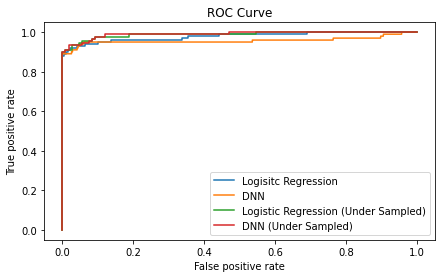

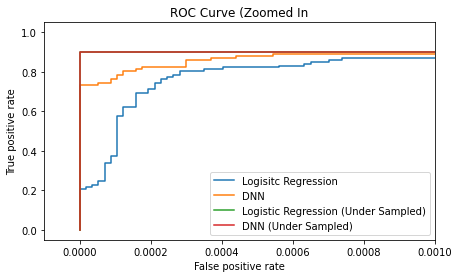

In [33]:
# Taking a look at the ROC
fpr_tf_us, tpr_tf_us, thresholds_tf_us = metrics.roc_curve(y_test_us, tf_probs_us, drop_intermediate=True)

# with plt.xkcd() as style:
plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf, fpr_us, tpr_us, fpr_tf_us, tpr_tf_us)
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN', 'Logistic Regression (Under Sampled)', 'DNN (Under Sampled)'])


plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, fpr_tf, tpr_tf, fpr_us, tpr_us, fpr_tf_us, tpr_tf_us)
plt.xlim((-0.0001,0.001))
plt.title('ROC Curve (Zoomed In')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Logisitc Regression', 'DNN', 'Logistic Regression (Under Sampled)', 'DNN (Under Sampled)'])

# Conclusion

There are a couple of things to unpack here. For one, the undersampling definitely helped. And in fact, it might have helped a lot more than can be seen from these visualizations because our regular dataset methods could have very well been overfitting the mostly Non-Fraudulent data. 

Another thing is that the DNN approach was a little bit of a better solution than a simple Logisitc Regression, although with the undersampled dataset the improvement was very miniscule. 

There a couple of things that can be done to take things further here. One would be to try oversampling instead of undersampling. That would mean we would have to somehow synthetically create more fraudulent transaction samples, but it might have a big performance boost since we would have a bigger dataset than the undersampled one which was only 900 and some odd number of samples. 

Another thing would be to try changing the neural network structure and hyperparamters to see if we can improve on the scores.